# Исследование поведения пользователей сервиса аренды самокатов GoFast

Для анализа поступили данные о выборке пользователей сервиса аренды самокатов GoFast из нескольких городов. 


**Цели исследования:**
1. Описать и визуализировать общую информацию о пользователях и поездках.
2. Проверить гипотезу о том, тратят ли пользователи с подпиской больше времени на поездки или нет.
3. Проверить гипотезу о том, не превышает ли среднее расстояние, которое проезжают пользователи с подпиской, 3130 метров (оптимальное расстояние с точки зрения износа самоката).
4. Проверить гипотезу о том, будет ли помесячная выручка по месяцам от пользователей с подпиской выше, чем от пользователей без подписки.


**Ход исследования:**
1. Обзор данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчет выручки
6. Проверка гипотез
7. Заключение


#### Обзор данных

##### Загрузка библиотек

Импортируем необходимые библиотеки для работы:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from scipy import stats as st
import numpy as np

##### Загрузка файлов

Загрузим файлы с данными о пользователях, поездках и подписках:

In [2]:
users = pd.read_csv("/datasets/users_go.csv")
rides = pd.read_csv("/datasets/rides_go.csv")
subsciptions = pd.read_csv("/datasets/subscriptions_go.csv")

##### Обзор данных

Выведем на экран первые несколько строк каждого датафрейма, изучив содержимое:

In [3]:
users.head(10)

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra
5,6,Регина,25,Краснодар,ultra
6,7,Игорь,23,Омск,ultra
7,8,Юрий,23,Краснодар,ultra
8,9,Ян,21,Пятигорск,ultra
9,10,Валерий,18,Екатеринбург,ultra


Датафрейм с пользователями содержит следующую информацию: 
1. id пользователя 
2. Имя
3. Возраст
4. Город 
5. Тип подписки

In [4]:
rides.head(10)

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22


Датафрейм с поездками содержит следующую информацию: 

1. id пользователя, совершившего поездку
2. Расстояние, которое преодолел пользователь в течение поездки
3. Продолжительность поездки 
4. Дата поездки

In [5]:
subsciptions.head(2)

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Датафрейм с подписками содержит следующую информацию:
1. Тип подписки
2. Стоимость минуты поездки
3. Стоимость начала поездки
4. Стоимость подписки

**Вывод:** На первый взгляд, аномалии в данных не обнаружены.

#### Шаг 2. Предобработка данных

##### Приведение столбца date к типу даты в pandas

Проверим, какие типы есть в датафрейме с поездкам:

In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Сейчас тип переменной date - object. Необходимо привести данную переменную к типу даты:

In [7]:
rides["date"] = pd.to_datetime(rides["date"])

Убедимся, что переменная имеет правильный тип:

In [8]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


##### Создание нового столбца с номером месяца

Создадим новый столбец с номером месяца в датафрейме в поездке:

In [9]:
rides["month"] = rides["date"].dt.month

Убедимся, что новый столбец был создан:

In [10]:
rides[["date", "month"]].head(10)

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8
5,2021-10-09,10
6,2021-10-19,10
7,2021-11-06,11
8,2021-11-14,11
9,2021-11-22,11


##### Обработка пропущенных значений

Оценим количество пропусков в каждом из датафреймов:

In [11]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [12]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

Пропуски не были обнаружены, обработка не потребовалась.

##### Обработка дубликатов

Оценим количество явных дубликатов в датафрейме с пользователями:

In [13]:
users.duplicated().sum()

31

Удалим найденные дубликаты:

In [14]:
users = users.drop_duplicates()

Проверим, что дубликаты были устранены:

In [15]:
users.duplicated().sum()

0

Оценим количество явных дубликатов в датафрейме с пользователями:

In [16]:
rides.duplicated().sum()

0

Дубликаты отсутствуют.

Начнем поиск неявных дубликатов: 

In [17]:
users["city"].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

Среди городов неявные дубликаты не обнаружены.

**Вывод:** Качество исходных данных оказалось высоким: пропущенные значения отсутствовали, явные дубликаты наблюдались в небольшом количестве, неявные дубликаты не были обнаружены.

#### Шаг 3. Исследовательский анализ данных

##### Частота встречаемости городов

Построим столбиковую диаграмму:

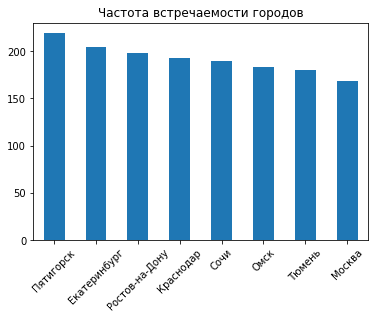

In [18]:
users["city"].value_counts().plot.bar(rot=45, title = "Частота встречаемости городов");

Согласно диаграмме, города встречаются примерно одинаково.

##### Соотношение пользователей с подпиской и без подписки

Построим круговую диаграмму:

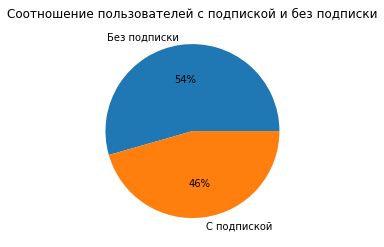

In [19]:
users.groupby("subscription_type")["user_id"].count().plot.pie(autopct='%1.0f%%', labels = ["Без подписки", "С подпиской"], ylabel="")
plt.title("Соотношение пользователей с подпиской и без подписки");

Видим, что чуть больше половины (54%) пользователей пользуются сервисом без подписки.

##### Возраст пользователей

Построим диаграмму частот:

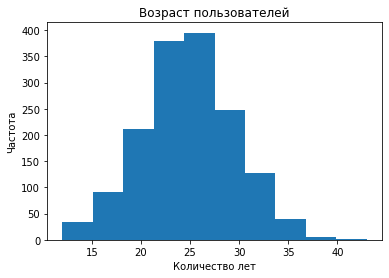

In [20]:
plt.hist(users["age"]) 
plt.title("Возраст пользователей")
plt.xlabel("Количество лет")
plt.ylabel("Частота")
plt.show();

Построим диаграмму размаха:

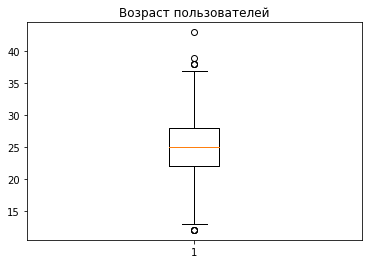

In [21]:
plt.boxplot(users["age"])
plt.title("Возраст пользователей")
plt.show()

Вычислим статистические показатели:

In [22]:
users["age"].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

На основе графиков и вычисленных статистических показателей, можно увидеть, что возраст большинства пользователей сервиса от 22 до 28 лет, максимальный возраст составляет 43 года, минимальный возраст - 12 лет.

##### Расстояние, которое пользователь преодолел за одну поездку

Построим гистограмму:

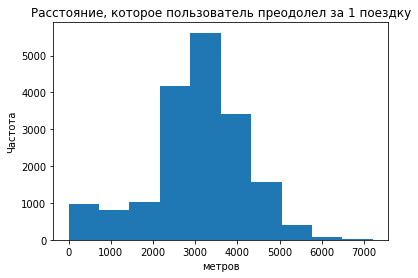

In [23]:
plt.hist(rides["distance"])
plt.title("Расстояние, которое пользователь преодолел за 1 поездку")
plt.xlabel("метров")
plt.ylabel("Частота")
plt.show();

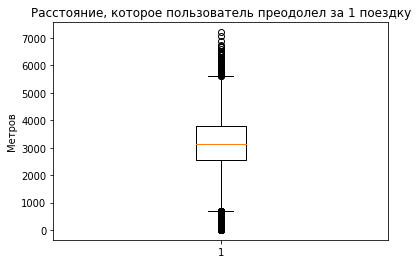

In [24]:
plt.boxplot(rides["distance"])
plt.title("Расстояние, которое пользователь преодолел за 1 поездку")
plt.ylabel("Метров")
plt.show()

In [25]:
rides["distance"].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

Согласно данных, среднее расстояние за одну поездку составляет 3070 метров, большинство значений находятся в пределах 2543 метров и 3776 метров. 

##### Продолжительность поездок

Построим гистограмму частот:

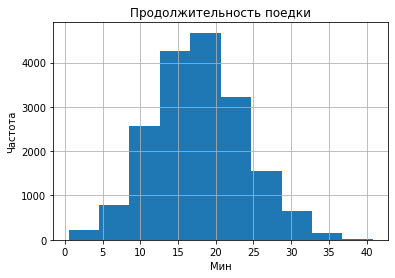

In [26]:
rides["duration"].hist()
plt.title("Продолжительность поедки")
plt.xlabel("Мин")
plt.ylabel("Частота")
plt.show();

Построим диаграмму размаха: 

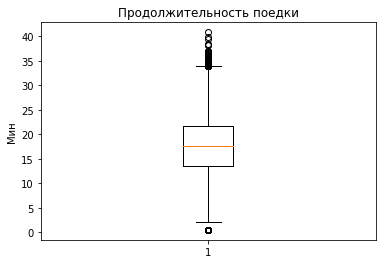

In [27]:
plt.boxplot(rides["duration"])
plt.title("Продолжительность поедки")
plt.ylabel("Мин")
plt.show()

Вычислим статистические показатели:

In [28]:
rides["duration"].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

Среднее расстояние за поездку составляет 17 минут, большинство поездок длятся от 13 до 21 минуты.

#### Шаг 4. Объединение данных

##### Объединение данных в один датафрейм

Оценим размеры датасетов до объединения:

In [29]:
users.shape[0]

1534

In [30]:
rides.shape[0]

18068

In [31]:
subsciptions.shape[0]

2

Объединим датафрейм с пользователями и подписками в один:

In [32]:
data = users.merge(subsciptions)

Оценим результат объединения:

In [33]:
data.head(15)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,6,0,199
1,2,Станислав,31,Омск,ultra,6,0,199
2,3,Алексей,20,Москва,ultra,6,0,199
3,4,Константин,26,Ростов-на-Дону,ultra,6,0,199
4,5,Адель,28,Омск,ultra,6,0,199
5,6,Регина,25,Краснодар,ultra,6,0,199
6,7,Игорь,23,Омск,ultra,6,0,199
7,8,Юрий,23,Краснодар,ultra,6,0,199
8,9,Ян,21,Пятигорск,ultra,6,0,199
9,10,Валерий,18,Екатеринбург,ultra,6,0,199


К получившемуся датафрейму присоединим датафрейм с поездками:

In [34]:
data = data.merge(rides)

Убедимся, что объединение всех датафреймов прошло успешно:

In [35]:
data.head(5)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8


Оценим размерность нового датасета:

In [36]:
data.shape[0]

18068

Значение соответствует ожидаемому.

##### Разделение полученного датафрейма на два с информацией о пользователей с подпиской и без

Отфильтруем получившийся объединенный датафрейм с информацией о пользователях с подпиской:

In [37]:
ultra = data.query("subscription_type == 'ultra'")

Убедимся в успешности процесса фильтрации:

In [38]:
ultra.head(5)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
0,1,Кира,22,Тюмень,ultra,6,0,199,4409.919140,25.599769,2021-01-01,1
1,1,Кира,22,Тюмень,ultra,6,0,199,2617.592153,15.816871,2021-01-18,1
2,1,Кира,22,Тюмень,ultra,6,0,199,754.159807,6.232113,2021-04-20,4
3,1,Кира,22,Тюмень,ultra,6,0,199,2694.783254,18.511000,2021-08-11,8
4,1,Кира,22,Тюмень,ultra,6,0,199,4028.687306,26.265803,2021-08-28,8


Отфильтруем получившийся объединенный датафрейм с информацией о пользователях без подписки:

In [39]:
free = data.query("subscription_type == 'free'")

Убедимся в успешности процесса фильтрации:

In [40]:
free.head(5)

,user_id,name,age,city,subscription_type,minute_price,start_ride_price,subscription_fee,distance,duration,date,month
6500,700,Айдар,22,Омск,free,8,50,0,2515.690719,14.944286,2021-01-02,1
6501,700,Айдар,22,Омск,free,8,50,0,846.932642,16.234663,2021-02-01,2
6502,700,Айдар,22,Омск,free,8,50,0,4004.434142,20.016628,2021-02-04,2
6503,700,Айдар,22,Омск,free,8,50,0,1205.911290,9.782872,2021-02-10,2
6504,700,Айдар,22,Омск,free,8,50,0,3047.379435,17.427673,2021-02-14,2


##### Расстояние и время поездок для каждой из категории пользователей (с подпиской и без)

Построим гистограммы по расстоянию для обеих категорий пользователей:

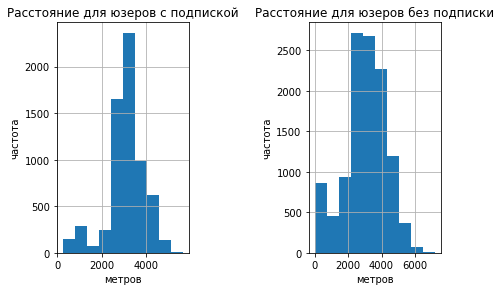

In [41]:
fig, axes = plt.subplots(1, 2)

ultra["distance"].hist(ax=axes[0])
free["distance"].hist(ax=axes[1])
axes[0].title.set_text('Расстояние для юзеров с подпиской')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.4)

axes[1].title.set_text('Расстояние для юзеров без подписки')
axes[0].set_xlabel('метров')
axes[0].set_ylabel('частота')
axes[1].set_xlabel('метров')
axes[1].set_ylabel('частота');

Рассчитаем статистические показатели:

In [42]:
print("Стат.показатели расстояния для пользователей с подпиской: ")
print(ultra["distance"].describe())
print("\n")
print("Стат.показатели расстояния для пользователей без подписки: ")
print(free["distance"].describe())

Стат.показатели расстояния для пользователей с подпиской: 
count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64


Стат.показатели расстояния для пользователей без подписки: 
count    11568.000000
mean      3045.495282
std       1246.173806
min          0.855683
25%       2366.562689
50%       3114.648465
75%       3905.697894
max       7211.007745
Name: distance, dtype: float64


Для пользователей с подпиской среднее расстояние составило 3115 метров, большая часть поездок имеет расстояние от 2785 метров до 3560 метров.

Для пользователей без подписки среднее расстояние составляет 3045 метров, большая часть поездок имеет расстояние от 2366 метров до 3905 метров.

Построим гистограммы по времени поездок для обеих категорий пользователей:

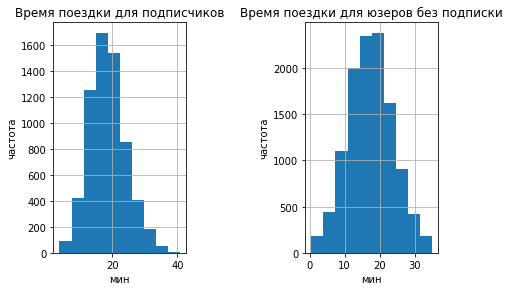

In [43]:
fig, axes = plt.subplots(1, 2)

ultra["duration"].hist(ax=axes[0])
free["duration"].hist(ax=axes[1])
axes[0].title.set_text('Время поездки для подписчиков')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.99, 
                    top=0.9, 
                    wspace=0.9, 
                    hspace=0.4)

axes[1].title.set_text('Время поездки для юзеров без подписки')
axes[0].set_xlabel('мин')
axes[0].set_ylabel('частота')
axes[1].set_xlabel('мин')
axes[1].set_ylabel('частота');

Вычислим статистические показатели:

In [44]:
print("Стат.показатели для времени поездки для подписчиков: ")
print(ultra["duration"].describe())
print("\n")
print("Стат.показатели для времени поездки для пользователей без подписки: ")
print(free["duration"].describe())

Стат.показатели для времени поездки для подписчиков: 
count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64


Стат.показатели для времени поездки для пользователей без подписки: 
count    11568.000000
mean        17.390909
std          6.326803
min          0.500000
25%         12.958437
50%         17.326890
75%         21.594071
max         34.948498
Name: duration, dtype: float64


Для пользователей с подпиской среднее время поездки составило 18 минут, большинство поездок имеют продолжительность от 14 до 21 минуты. Минимальное значение равно 3 минутам, максимальное значение равно 40 минутам.

Для пользователей без подписки среднее время поездки составило 17 минут, большинство поездок имеют продолжительность от 12 до 21 минуты. Минимальное значение равно полминуты, максимально значение составляет 35 минут.

#### Шаг 5. Подсчёт выручки

##### Cуммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

Округлим значение каждой поездки:

In [45]:
data['duration'] = np.ceil(data['duration']) 

Создадим новый датафрейм с суммарным расстоянием, количеством поездок и суммарным временем для каждого пользователя за каждый месяц:

In [46]:
monthly_data = pd.pivot_table(data, index=["user_id", "month"], values =["distance", "duration", "age", "subscription_type"], aggfunc= {"distance": sum, "duration": sum, "age": len, "subscription_type": min})
monthly_data

age      distance  duration subscription_type
user_id month                                               
1       1        2   7027.511294      42.0             ultra
        4        1    754.159807       7.0             ultra
        8        2   6723.470560      46.0             ultra
        10       2   5809.911100      32.0             ultra
        11       3   7003.499363      56.0             ultra
...            ...           ...       ...               ...
1534    6        2   3409.468534      26.0              free
        8        2   7622.453034      48.0              free
        9        1   4928.173852      23.0              free
        11       4  13350.015305      78.0              free
        12       1   2371.711192      16.0              free

[11331 rows x 4 columns]

Переименуем название столбцов на подходящие:

In [47]:
monthly_data = monthly_data.rename(columns={'age':'rides'})

##### Подсчет выручки

Добавим столбец с ежемесячной выручкой для каждого пользователя. Напишем функцию, которая возвращает значение выручки, в зависимости от типа подписки:

In [48]:
def user_profit(data):
    if data["subscription_type"] == 'ultra':
        return data["duration"] * 6 + 199
    else:
        return data["duration"] * 8 + data["rides"] * 50

Применим данную функцию к датафрейму, создав новый столбец:

In [49]:
monthly_data["profit"] = monthly_data.apply(user_profit, axis = 1)

Проверим успешность создания нового столбца:

In [50]:
monthly_data

rides      distance  duration subscription_type  profit
user_id month                                                         
1       1          2   7027.511294      42.0             ultra   451.0
        4          1    754.159807       7.0             ultra   241.0
        8          2   6723.470560      46.0             ultra   475.0
        10         2   5809.911100      32.0             ultra   391.0
        11         3   7003.499363      56.0             ultra   535.0
...              ...           ...       ...               ...     ...
1534    6          2   3409.468534      26.0              free   308.0
        8          2   7622.453034      48.0              free   484.0
        9          1   4928.173852      23.0              free   234.0
        11         4  13350.015305      78.0              free   824.0
        12         1   2371.711192      16.0              free   178.0

[11331 rows x 5 columns]

#### Шаг 6. Проверка гипотез

##### Проверка того, тратят ли пользователи с подпиской больше времени, чем пользователи без подписки.

Формулируем нулевую и альтернативную гипотезу:

**H0: Среднее время, которое тратят пользоваели с подпиской, равно среднему времени, которое тратят пользователи без подписки.**

**H1: Среднее время, которое тратят пользователи с подпиской, больше среднего времени, которое тратят пользователи без подписки.**



Для проверки данной гипотезы используется правосторонний статистический t-тест для независимых выборок:

In [51]:
results = st.ttest_ind(ultra["duration"], free["duration"], alternative = 'greater')

alpha = 0.05

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. p-value равен: ", results.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу. p-value равен: ", results.pvalue)

Отвергаем нулевую гипотезу. p-value равен:  1.2804098316645618e-34


**Вывод**: Нулевая гипотеза была отвергнута. Следовательно, пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

##### Проверка того, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров

Формулируем нулевую и альтернативную гипотезы:

**Н0: Среднее расстояние, которое проезжает пользователи с подпиской за одну поездку, равно 3130 метров.**

**H1: Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 310 метров.**


Для проверки данной гипотезы используется правосторонний статистический t-тест для одной выборки:

In [52]:
value = 3130
alpha = 0.05

results = st.ttest_1samp(ultra["distance"], value, alternative="greater")

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. p-value равен: ", results.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу. p-value равен: ", results.pvalue)

Не получилось отвергнуть нулевую гипотезу. p-value равен:  0.9195368847849785


Недостаточно данных, чтобы отвергнуть нулевую гипотезу, следовательно, среднее расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130 метров.

##### Проверка того, что помесячная выручка от пользователей с подпиской превышает таковую от пользователей без подписки

Сформулируем нулевую и альтернативную гипотезы:

**H0: Среднее значение помесячной выручки от пользователей с подпиской равна среднему значению помесячной выручки от пользователей без подписки.**

**H1: Среднее значение помесячной выручки от пользователей с подпиской превышает таковую от пользоватеей без подписки.**

Для проверки данной гипотезы используется правосторонний статистический t-тест для независимых выборок:

In [53]:
results = st.ttest_ind(monthly_data.query("subscription_type == 'ultra'")["profit"], monthly_data.query("subscription_type == 'free'")["profit"], alternative = 'greater')
alpha = 0.05
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. p-value равен: ", results.pvalue)
else:
    print("Не получилось отвергнуть нулевую гипотезу. p-value равен: ", results.pvalue)

Отвергаем нулевую гипотезу. p-value равен:  1.8850394384715216e-31


Нулевая гипотеза была опровергнута. Следовательно, помесячная выручка от пользователей с подпиской превышает таковую от пользователей без подписки.

##### Предложение для статистического теста для проверки снижения обращения в техподдержку

Нужно использовать статистический левосторонний t-test для зависимых выборок, до и после изменений. 

Формулировки нулевой и альтернативных гипотез звучат следующим образом:

**H0: Среднее количество обращений в техподдержку после изменений равно среднему количеству обращений в техподдержку до изменений.**

**H1:  Среднее количество обращений в техподдержку после изменений меньше среднего количества обращений в техподдержку до изменений.**

Пример реализация теста:


In [54]:
from scipy import stats as st
   
sample1 = [] # выборка до изменений
sample2 = [] # выборка после изменений

alpha = 0.05 # выбранный уровень статистической значимости
 
results = st.ttest_rel(sample1, sample2, alternative="less")
    
if results.pvalue < alpha: 
   
    print("Отвергнуть нулевую гипотезу")
    
else:
    
    print("Не получилось отвергнуть нулевую гипотезу")
    

Не получилось отвергнуть нулевую гипотезу


#### Заключение

В ходе исследования был проведен поэтапный исследовательский и статистический анализ данных. Этап предобработки показал высокое качество исходных данных. На этапе исследовательского анализа были визуализированы ключевые характеристики данных: частота встречаемости городов, соотношение пользователей с подпиской и без подписки, возраст пользователей, расстояние, которое преодолел пользователь за одну поездку и продолжительность поездок.

Общие выводы по разделу с исследовательским анализом таковы:

**1) Точки во всех городах развиты примерно одинаково (в абсолютных цифрах): примерно одинаковое количество юзеров пользуются ими.**

*Потенциальная точка роста для бизнеса в этом аспекте: возможно, следует оценить реальную эффективность точек по городам, поскольку население городов разное, среди подборки есть так и крупные города-миллионники, а так и есть населением менее 300 тысяч.*

**2) Количество пользователей с подпиской составляет меньший процент, чем пользователи без подписки. Однако, это тоже существенный процент - чуть меньше половины (46%).**

**3) Большинство пользователей достаточно молоды: их возраст составляет от 22 до 28 лет.**

*Потенциальная точка роста для бизнеса:* 
1) Оценить какая возрастная категория приносит больше прибыли.

2) Исходя из результатов пункта 1, перестроить маркетинговые стратегии таким образом, чтобы сервис был максимально привлекательным для молодежи, либо пытаться привлечь другую возрастную аудиторию (но здесь есть риски, так как самокат приспособлен для более активных физически людей, что больше характерно именно для молодых людей).

**4) Основная часть поездок занимает от 2500 до 3800 метров. Медианное значение - 3133 метров.**

*Потенциальная точка роста для бизнеса: воспользоваться этой информацией, чтобы выявить, какой тип самоката оптимален по соотношению изностойкости/его цены/прибыли, которую он приносит.*


**5) Среднее расстояние за поездку составляет 17 минут, большинство поездок длятся от 13 до 21 минуты.**

*Потенциальная точка роста для бизнеса: использовать информацию по реальному времени поездок для тестирования новых вариантов тарификации для закрепления лояльности клиентов и повышения выручки.* 


Дальнейшие манипуляции с данными включали расчет различных месячных показателей для каждого пользователя: суммарного расстояния, количество поездок, суммарного времени и помесячной выручки.

Результатом статистического анализа данных стало подтверждение следующих гипотез:

**1. Гипотеза "Пользователи с подпиской тратят больше времени, чем пользователи без подписки" верна (p-value < 0.05, нулевая гипотеза была отвергнута).**

**2. Гипотеза "Среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров" верна (p-value > 0.05, нулевую гипотезу не получилось отвергнуть).**

**3. Гипотеза "Помесячная выручка от пользователей с подпиской превышает таковую от пользователей без подписки" верна (p-value < 0.05, нулевая гипотеза была отвергнута).**

Исходя из данных, для бизнеса необходимо увеличивать количество пользователей с подпиской, так как они дают более высокую выручку и оптимально, с точки зрения износа самоката, совершают поездки.

Также дополнительной рекомендацией для бизнеса является то, что **необходимо использовать статистический тест равенства средних для зависимых выборок, до и после изменений в случае, если необходимо проверить, снизилось количество обращений в техподдержку или нет.**
